In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [2]:
#Read NO-NO2-NOx Series
dataFrame = pd.read_excel("../data/DataAirTrain.xlsx",index_col= 'time', sheet_name="NO-NO2-NOx")
dataFrame = dataFrame.tail(1000)

In [3]:
dataFrame[['NO','NOx']] = dataFrame[['NO','NOx']].interpolate(method='linear')

In [4]:
#Using linear regression to fill missing data
linearModel = LinearRegression()
nanMask = dataFrame[['NO2']].isna()
nanMask = nanMask['NO2']

xTrain = dataFrame.loc[~nanMask,['NOx']]
yTrain = dataFrame.loc[~nanMask,['NO2']]

linearModel.fit(xTrain, yTrain)

xTest = dataFrame.loc[nanMask, ['NOx']]
yTest = linearModel.predict(xTest)
dataFrame.loc[nanMask,['NO2']] = yTest
print(dataFrame.loc[nanMask,['NO2']])

                           NO2
time                          
2019-08-15 17:00:00  82.912849
2019-08-24 13:00:00   8.495087
2019-08-24 14:00:00   8.518238
2019-08-29 12:00:00   8.529813
2019-08-29 13:00:00   8.286732
2019-08-29 14:00:00   7.661664
2019-08-29 15:00:00   8.645567
2019-08-30 13:00:00   9.062278
2019-08-30 14:00:00   8.032074
2019-08-30 15:00:00   8.066800
2019-08-30 16:00:00   8.900224
2019-08-31 14:00:00   8.842347
2019-08-31 15:00:00   8.275156
2019-08-31 16:00:00   8.807621
2019-09-01 12:00:00   9.015977
2019-09-01 13:00:00   7.951047
2019-09-01 14:00:00   7.719541
2019-09-01 15:00:00   7.858445
2019-09-01 16:00:00   8.252006
2019-09-02 05:00:00   8.622416
2019-09-02 12:00:00   8.495087
2019-09-02 13:00:00   8.113102
2019-09-02 14:00:00   7.823719
2019-09-02 15:00:00   8.147828
2019-09-02 16:00:00   8.448786
2019-09-02 17:00:00   8.333033
2019-09-02 18:00:00   8.576115
2019-09-02 20:00:00   8.680293
2019-09-02 21:00:00   8.610841
2019-09-02 22:00:00   8.333033
2019-09-

In [5]:
#Fix gap in time index
dataFrame = dataFrame.resample('H').interpolate(method='linear')

<AxesSubplot:xlabel='time'>

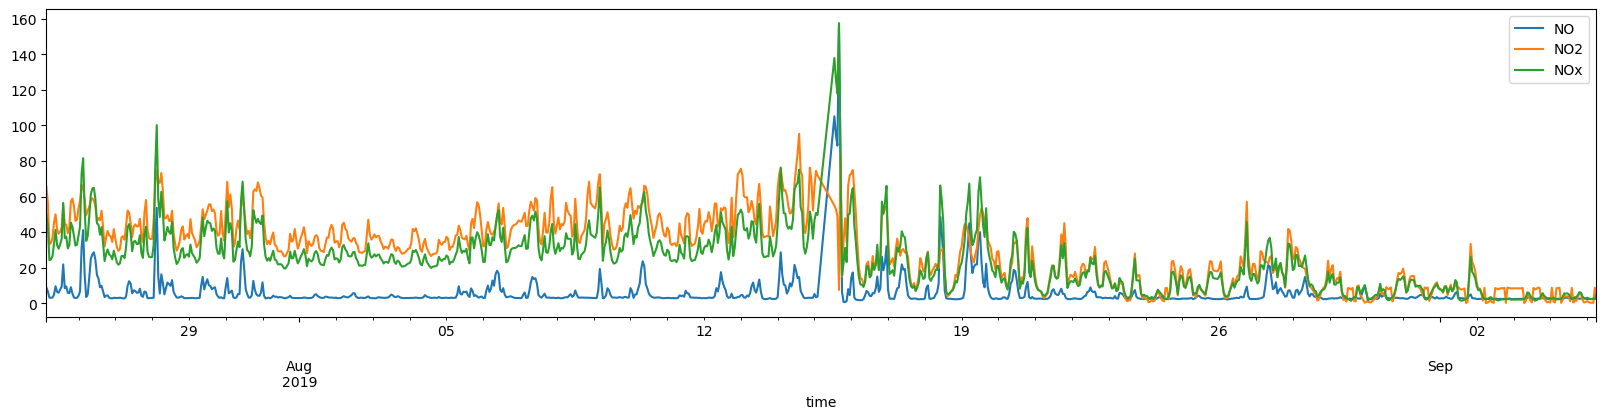

In [6]:
dataFrame.plot(figsize= (20,4))

In [7]:
from statsmodels.tsa.stattools import adfuller
def stationary(var, desc):
    print(
        f"'{desc}' is stationary: "
        f"{adfuller(var)[0] < adfuller(var)[4]['1%']}.")
stationary(dataFrame.NO, 'NO')
stationary(dataFrame.NO2, 'NO2')
stationary(dataFrame.NOx, 'NOx')

'NO' is stationary: True.
'NO2' is stationary: False.
'NOx' is stationary: False.


In [8]:
trainSet = dataFrame[: -48]
testSet = dataFrame[-48: ]
dataFrameCopy = dataFrame
dataFrame = trainSet

In [9]:
def Forecast(ARIMA_model, periods=48):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    # index_of_fc = pd.date_range(dataFrame.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='H')
    index_of_fc = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods = n_periods, freq="H")
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    return [fitted_series, lower_series, upper_series]

In [10]:
def AutoArima(x):
    # return auto_arima(x,d=0)
    return auto_arima(  x, d=None, test = 'adf', D=1, m=24,
                        seasonal = True, error_action = 'ignore')

In [11]:
len = 120
step = 48

In [12]:
resSarima = []
resSarima.append(AutoArima(dataFrame['NO'].tail(len)))
resSarima.append(AutoArima(dataFrame['NO2'].tail(len)))
resSarima.append(AutoArima(dataFrame['NOx'].tail(len)))


In [13]:
def Plot(res, test):
    plt.figure(figsize=(15,4))
    plt.plot(res[0], color='darkgreen',label='predict')
    plt.fill_between(res[1].index, 
                    res[1], 
                    res[2], 
                    color='k', alpha=.15)
    plt.title(test.columns.values)
    plt.plot(test,label='test')
    plt.legend()
    plt.show()

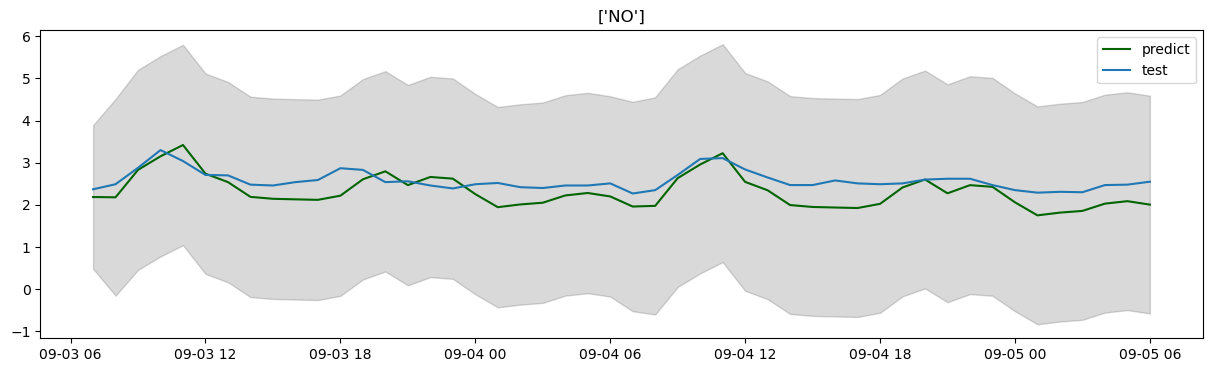

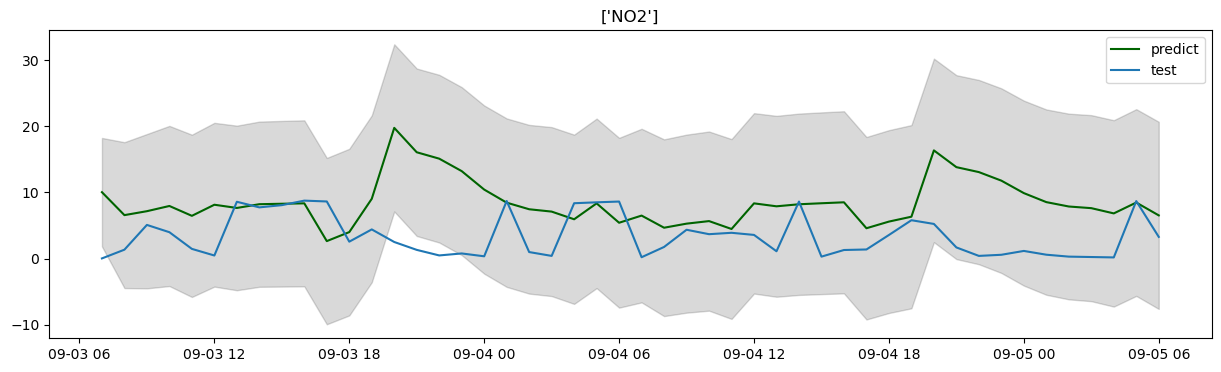

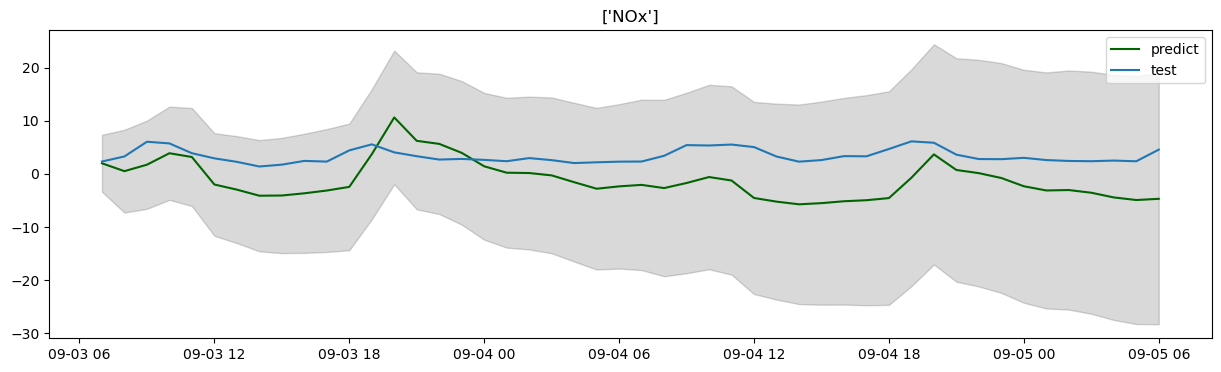

In [14]:
predict = []
res = Forecast(resSarima[0])
Plot(res, testSet[['NO']])
predict.append(res[0])

res = Forecast(resSarima[1])
Plot(res, testSet[['NO2']])
predict.append(res[0])

res = Forecast(resSarima[2])
Plot(res, testSet[['NOx']])
predict.append(res[0])

In [15]:
step = 48
dateTimeIndex = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods=step, freq="H")
idx = pd.Index(dateTimeIndex, name='time')
dataFramePredicted = pd.DataFrame(predict)
dataFramePredicted = dataFramePredicted.transpose()
dataFramePredicted.index = idx
dataFramePredicted.columns = dataFrame.columns.values
print(dataFramePredicted)

                           NO        NO2        NOx
time                                               
2019-09-03 07:00:00  2.186627  10.024777   2.011035
2019-09-03 08:00:00  2.179780   6.559286   0.525237
2019-09-03 09:00:00  2.831116   7.153865   1.738946
2019-09-03 10:00:00  3.152779   7.941765   3.905161
2019-09-03 11:00:00  3.420215   6.452934   3.193402
2019-09-03 12:00:00  2.739535   8.129473  -1.989729
2019-09-03 13:00:00  2.540563   7.643277  -2.957561
2019-09-03 14:00:00  2.189953   8.209237  -4.107164
2019-09-03 15:00:00  2.144558   8.277593  -4.066807
2019-09-03 16:00:00  2.131589   8.339449  -3.653326
2019-09-03 17:00:00  2.119503   2.634864  -3.127439
2019-09-03 18:00:00  2.218541   3.995009  -2.440936
2019-09-03 19:00:00  2.607045   9.024812   3.710193
2019-09-03 20:00:00  2.796415  19.740584  10.656564
2019-09-03 21:00:00  2.468636  16.056682   6.243456
2019-09-03 22:00:00  2.662156  15.088397   5.669815
2019-09-03 23:00:00  2.622163  13.206981   3.978885
2019-09-04 0

In [16]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
tmp = []
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,0], testSet.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,1], testSet.iloc[:,1]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,2], testSet.iloc[:,2]))
metric = pd.DataFrame(tmp, index=dataFramePredicted.columns.values)
print(metric)

          mape        me       mae        mpe      rmse      corr    minmax
NO    0.121833 -0.256654  0.307446  -0.102896  0.351240  0.805303  0.121011
NO2  18.864730  5.059471  5.642626  18.796711  7.209854 -0.235373  0.598179
NOx   1.665422 -4.488355  5.054552  -1.499587  5.615303  0.302483  1.621920


C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\3333627943.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\3333627943.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\3333627943.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\Admin\AppData\Local\Temp\ipykernel_16408\3333627943.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `ob